In [1]:
%matplotlib inline
import os, shutil
import sys
sys.path.append("..")
import numpy as np
from IPython.display import Image
import pandas as pd
import matplotlib.pyplot as plt

import flopy as flopy
import pyemu

In [2]:
import freyberg_setup
freyberg_setup.setup_pest_gr()
working_dir = freyberg_setup.WORKING_DIR_GR
pst_name = freyberg_setup.PST_NAME_GR

['.DS_Store', 'botm.ref', 'extract_zone_array.py', 'forecasts_true.csv', 'freyberg.bas', 'freyberg.dbf', 'freyberg.dis', 'freyberg.hds', 'freyberg.heads', 'freyberg.heads_potobs.ins', 'freyberg.hyd', 'freyberg.list', 'freyberg.locations', 'freyberg.mpbas', 'freyberg.mpenpt', 'freyberg.mplist', 'freyberg.mpnam', 'freyberg.mppthln', 'freyberg.mpsim', 'freyberg.oc', 'freyberg.pcg', 'freyberg.rivflux', 'freyberg.shp', 'freyberg.shx', 'freyberg.travel', 'freyberg.truth.lpf', 'freyberg.truth.nam', 'freyberg.truth.rch', 'freyberg.truth.riv', 'freyberg.truth.wel', 'hk.truth.ref', 'hk.zones', 'ibound.ref', 'kzone.ref', 'mpath.in', 'potobs_group.csv', 'Process_output.py', 'really_noisy_heads.txt', 'run_true_model.py', 'strt.ref', 'Weights_and_best_PHI.xlsx']

changing model workspace...
   freyberg_gr
FloPy is using the following executable to run the model: /Users/jwhite/Dev/GW1876/activities/freyberg_grid_ies/freyberg_gr/mfnwt

                                  MODFLOW-NWT-SWR1 
    U.S. GEOLO

In [3]:
pst = pyemu.Pst(os.path.join(working_dir,pst_name))
obs = pst.observation_data
obs.loc[obs.obgnme=="calhead","weight"] = 0.5
par = pst.parameter_data
hk_par = par.loc[par.pargp=="hk"].copy()
hk_par.head()

,parnme,partrans,parchglim,parval1,parlbnd,parubnd,pargp,scale,offset,dercom
parnme,,,,,,,,,,
hk_i00_j00,hk_i00_j00,log,factor,5.0,0.5,50.0,hk,1.0,0.0,1
hk_i00_j01,hk_i00_j01,log,factor,5.0,0.5,50.0,hk,1.0,0.0,1
hk_i00_j02,hk_i00_j02,log,factor,5.0,0.5,50.0,hk,1.0,0.0,1
hk_i00_j03,hk_i00_j03,log,factor,5.0,0.5,50.0,hk,1.0,0.0,1
hk_i00_j04,hk_i00_j04,log,factor,5.0,0.5,50.0,hk,1.0,0.0,1


### build a prior

In [4]:
m = flopy.modflow.Modflow.load(freyberg_setup.MODEL_NAM,model_ws=working_dir,load_only=["upw"],check=False)

In [5]:
hk_par.loc[:,"i"] = hk_par.parnme.apply(lambda x: int(x.split('_')[1][1:]))
hk_par.loc[:,"j"] = hk_par.parnme.apply(lambda x: int(x.split('_')[2][1:]))
hk_par.loc[:,"x"] = m.sr.xcentergrid[hk_par.i,hk_par.j]
hk_par.loc[:,"y"] = m.sr.ycentergrid[hk_par.i,hk_par.j]

In [6]:
v = pyemu.geostats.ExpVario(contribution=1.0,a=2500.0)
gs = pyemu.geostats.GeoStruct(variograms=v)

In [7]:
cov = pyemu.helpers.pilotpoint_prior_builder(pst=pst,struct_dict={gs:[hk_par]})

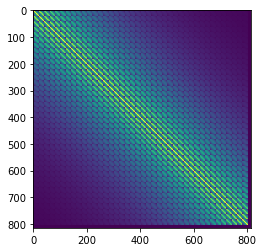

In [8]:
plt.imshow(cov.x)

In [9]:
os.chdir(working_dir)

In [10]:
pst.filename = pst_name
ies = pyemu.EnsembleSmoother(pst=pst,parcov=cov,num_slaves=10,slave_dir=".")

``EnsembleSmoother.initialize()`` does lots of things for you:
- make draws from parcov for the initial ``ParameterEnsemble``
- make draws from obscov for the "target" ``ObservationEnsemble``
- runs the initial ``ParameterEnsemble`` forward to get the initial ``ObservationEnsemble``

In [11]:
ies.initialize(num_reals=100)

run():./sweep freyberg_gr.pst /h :4004 1>_master_stdout.dat 2>_master_stderr.dat
slave:sweep freyberg_gr.pst /h localhost:4004 in ../slave_0
slave:sweep freyberg_gr.pst /h localhost:4004 in ../slave_1
slave:sweep freyberg_gr.pst /h localhost:4004 in ../slave_2
slave:sweep freyberg_gr.pst /h localhost:4004 in ../slave_3
slave:sweep freyberg_gr.pst /h localhost:4004 in ../slave_4
slave:sweep freyberg_gr.pst /h localhost:4004 in ../slave_5
slave:sweep freyberg_gr.pst /h localhost:4004 in ../slave_6
slave:sweep freyberg_gr.pst /h localhost:4004 in ../slave_7
slave:sweep freyberg_gr.pst /h localhost:4004 in ../slave_8
slave:sweep freyberg_gr.pst /h localhost:4004 in ../slave_9


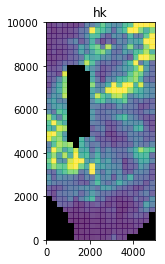

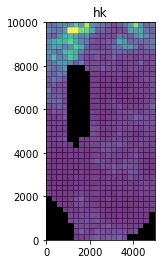

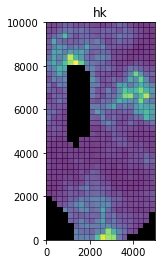

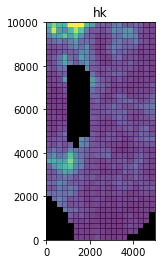

In [12]:
for real in ies.parensemble.index[:4]:
    arr = np.zeros((m.nrow,m.ncol))
    arr[hk_par.i,hk_par.j] = ies.parensemble.loc[real,hk_par.parnme]
    m.upw.hk[0] = arr
    m.upw.hk[0].plot(alpha=0.5)
    plt.show()

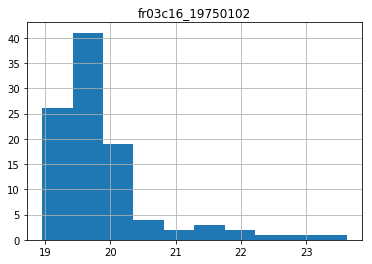

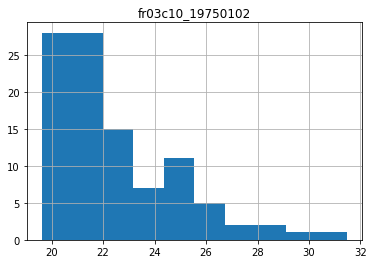

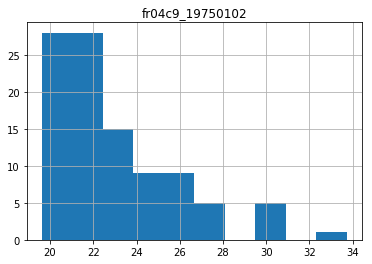

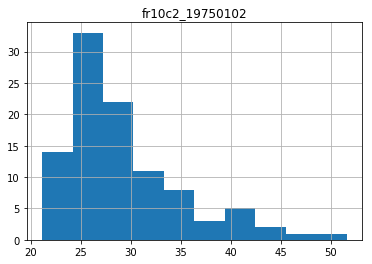

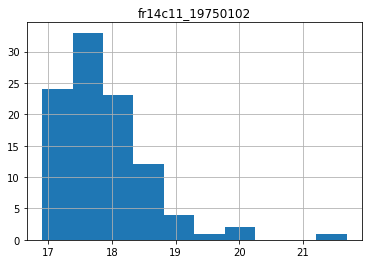

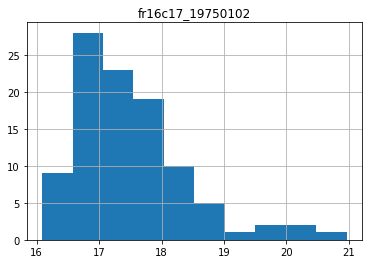

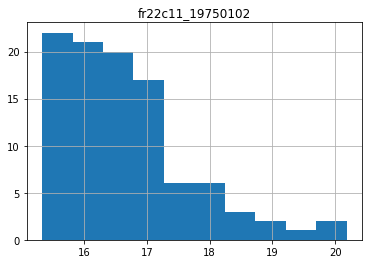

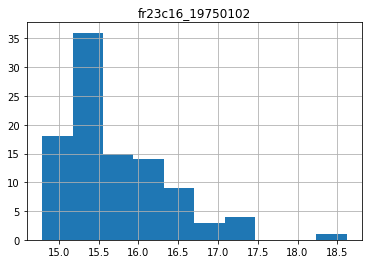

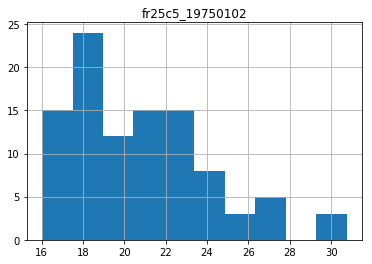

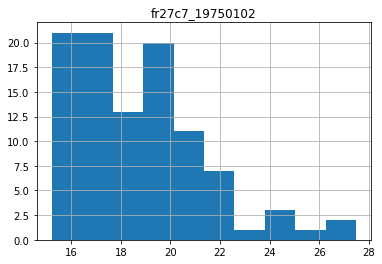

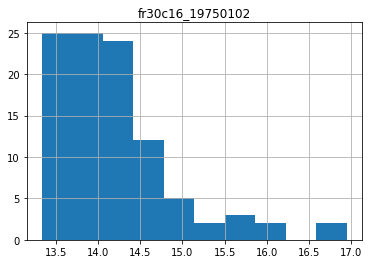

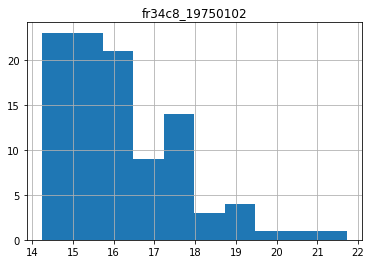

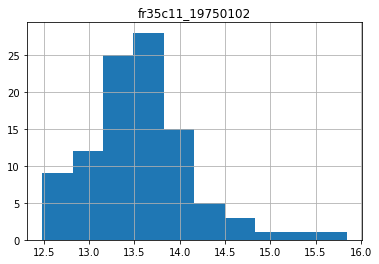

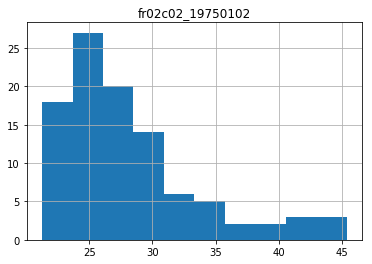

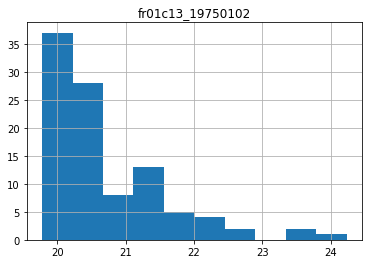

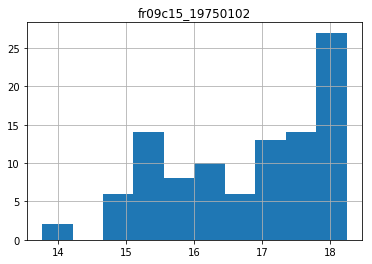

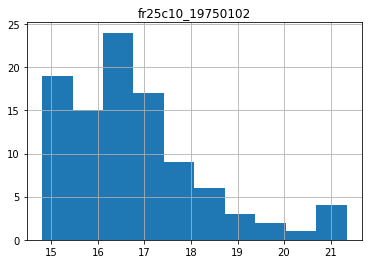

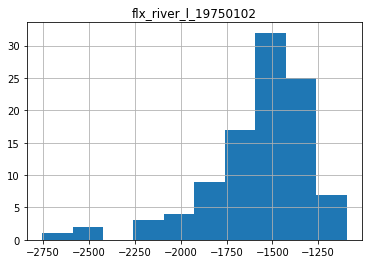

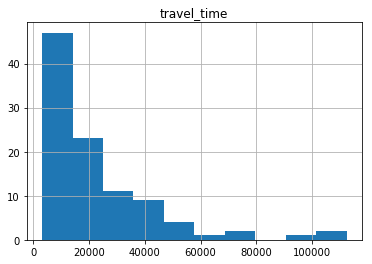

In [13]:
for forecast in pst.forecast_names:
    ax = ies.obsensemble.loc[:,forecast].hist(bins=10)
    ax.set_title(forecast)
    plt.show()

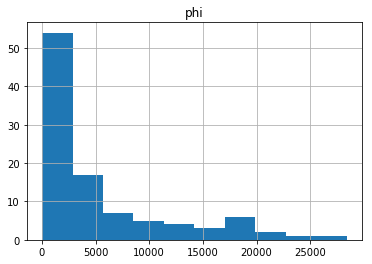

In [14]:
ies.current_phi.hist(bins=10)
plt.show()

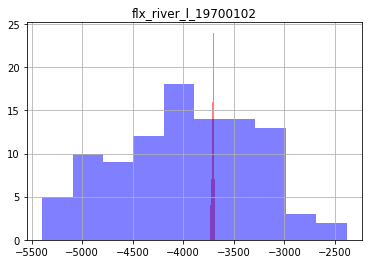

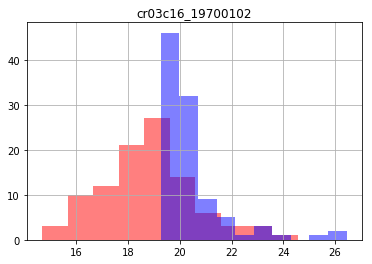

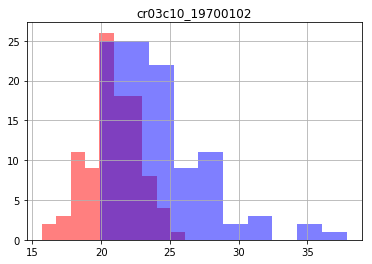

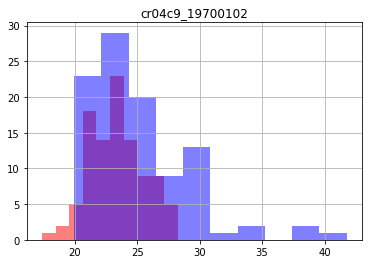

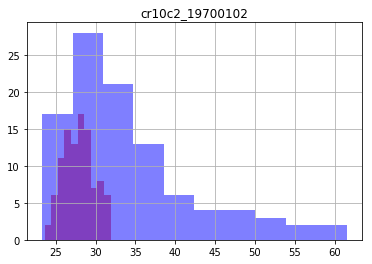

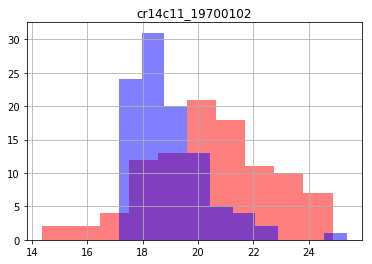

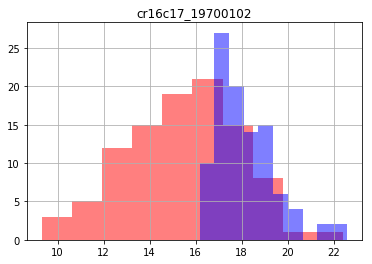

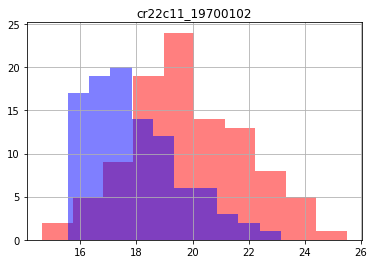

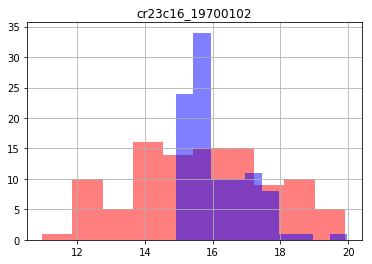

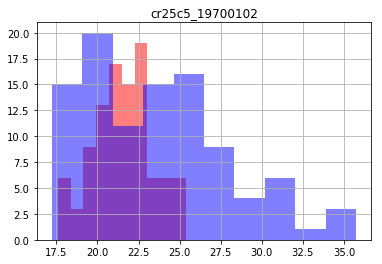

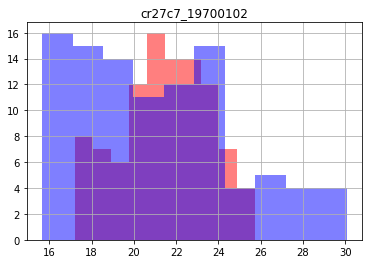

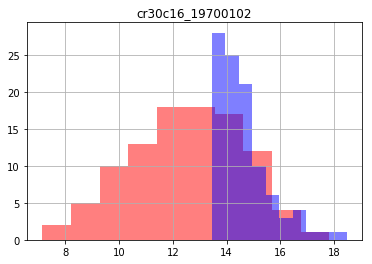

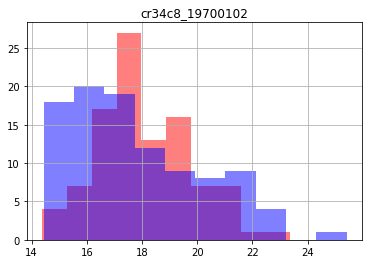

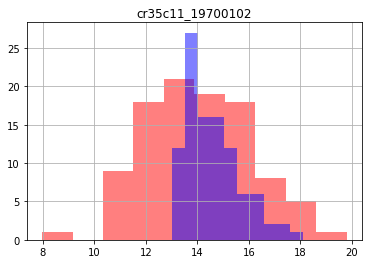

In [15]:
for oname in pst.nnz_obs_names:
    ax = ies.obsensemble_0.loc[:,oname].hist(bins=10,alpha=0.5,color='r')
    ies.obsensemble.loc[:,oname].hist(bins=10,ax=ax,alpha=0.5,color='b')
    ax.set_title(oname)
    plt.show()

``EnsembleSmoother.update()`` propagates the ensemble forward, updating the ``ParameterEnsemble`` through the GLM algorithm, then runs the new ``ParameterEnsemble``

In [16]:
ies.update()

run():./sweep freyberg_gr.pst /h :4004 1>_master_stdout.dat 2>_master_stderr.dat
slave:sweep freyberg_gr.pst /h localhost:4004 in ../slave_0
slave:sweep freyberg_gr.pst /h localhost:4004 in ../slave_1
slave:sweep freyberg_gr.pst /h localhost:4004 in ../slave_2
slave:sweep freyberg_gr.pst /h localhost:4004 in ../slave_3
slave:sweep freyberg_gr.pst /h localhost:4004 in ../slave_4
slave:sweep freyberg_gr.pst /h localhost:4004 in ../slave_5
slave:sweep freyberg_gr.pst /h localhost:4004 in ../slave_6
slave:sweep freyberg_gr.pst /h localhost:4004 in ../slave_7
slave:sweep freyberg_gr.pst /h localhost:4004 in ../slave_8
slave:sweep freyberg_gr.pst /h localhost:4004 in ../slave_9


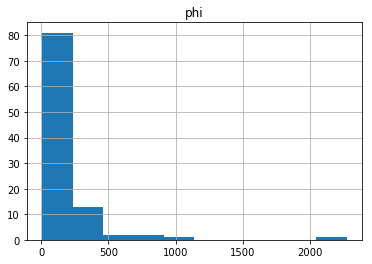

In [17]:
ies.current_phi.hist(bins=10)
plt.show()

Notice how much the ``phi`` distribution has decreased compared to the initialized ``EnsembleSmoother``: Nice!

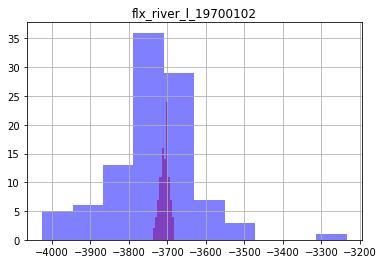

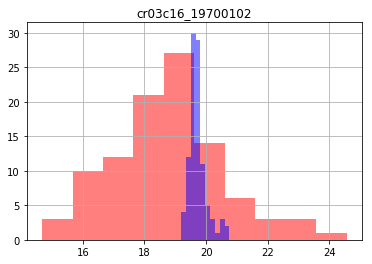

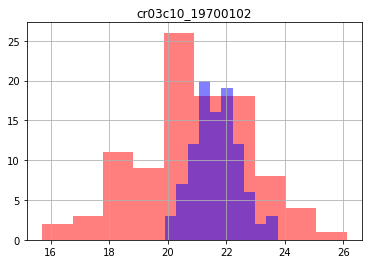

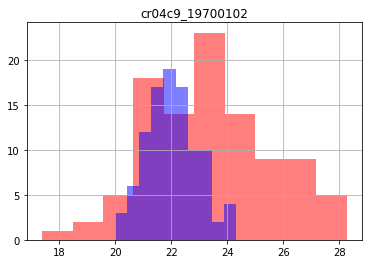

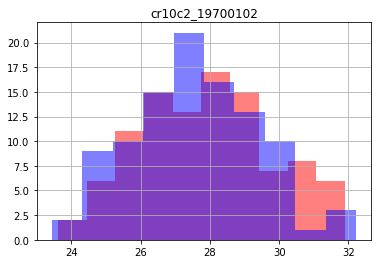

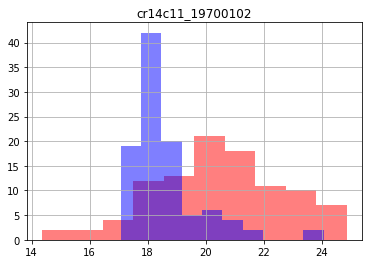

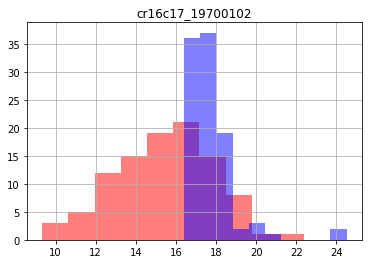

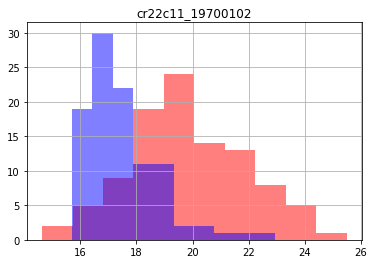

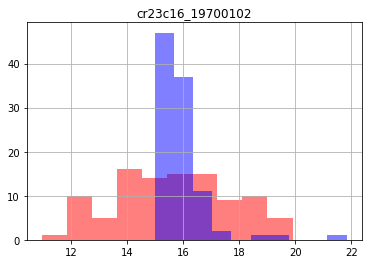

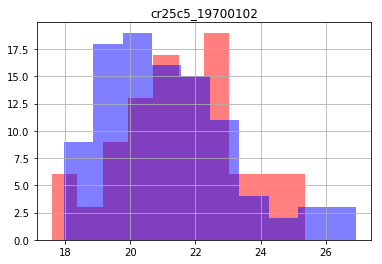

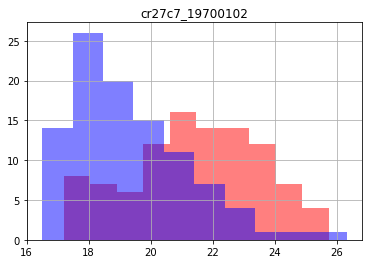

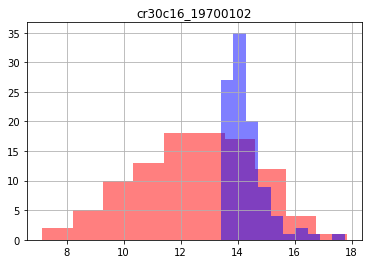

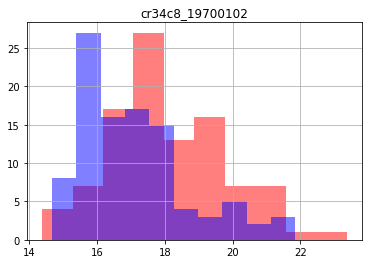

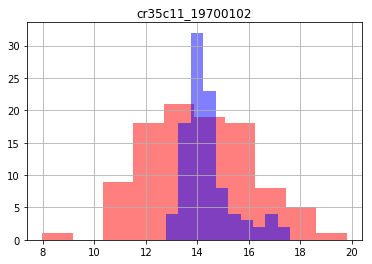

In [18]:
for oname in pst.nnz_obs_names:
    ax = ies.obsensemble_0.loc[:,oname].hist(bins=10,alpha=0.5,color='r')
    ies.obsensemble.loc[:,oname].hist(bins=10,ax=ax,alpha=0.5,color='b')
    ax.set_title(oname)
    plt.show()

run():./sweep freyberg_gr.pst /h :4004 1>_master_stdout.dat 2>_master_stderr.dat
slave:sweep freyberg_gr.pst /h localhost:4004 in ../slave_0
slave:sweep freyberg_gr.pst /h localhost:4004 in ../slave_1
slave:sweep freyberg_gr.pst /h localhost:4004 in ../slave_2
slave:sweep freyberg_gr.pst /h localhost:4004 in ../slave_3
slave:sweep freyberg_gr.pst /h localhost:4004 in ../slave_4
slave:sweep freyberg_gr.pst /h localhost:4004 in ../slave_5
slave:sweep freyberg_gr.pst /h localhost:4004 in ../slave_6
slave:sweep freyberg_gr.pst /h localhost:4004 in ../slave_7
slave:sweep freyberg_gr.pst /h localhost:4004 in ../slave_8
slave:sweep freyberg_gr.pst /h localhost:4004 in ../slave_9


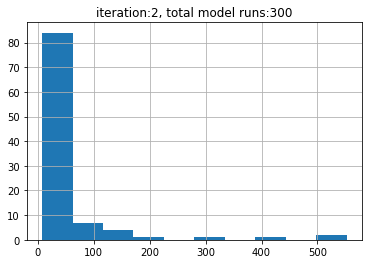

run():./sweep freyberg_gr.pst /h :4004 1>_master_stdout.dat 2>_master_stderr.dat
slave:sweep freyberg_gr.pst /h localhost:4004 in ../slave_0
slave:sweep freyberg_gr.pst /h localhost:4004 in ../slave_1
slave:sweep freyberg_gr.pst /h localhost:4004 in ../slave_2
slave:sweep freyberg_gr.pst /h localhost:4004 in ../slave_3
slave:sweep freyberg_gr.pst /h localhost:4004 in ../slave_4
slave:sweep freyberg_gr.pst /h localhost:4004 in ../slave_5
slave:sweep freyberg_gr.pst /h localhost:4004 in ../slave_6
slave:sweep freyberg_gr.pst /h localhost:4004 in ../slave_7
slave:sweep freyberg_gr.pst /h localhost:4004 in ../slave_8
slave:sweep freyberg_gr.pst /h localhost:4004 in ../slave_9


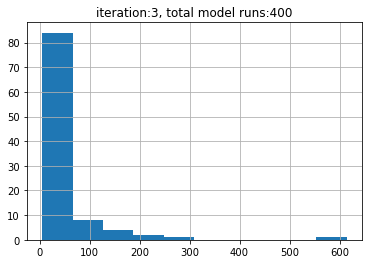

In [19]:
for i in range(2):
    ies.update()
    phi = ies.current_phi
    ax = plt.subplot(111)
    phi.hist(bins=10,ax=ax)
    ax.set_title("iteration:{0}, total model runs:{1}".format(ies.iter_num,ies.total_runs))
    plt.show()

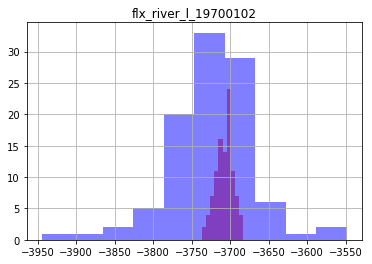

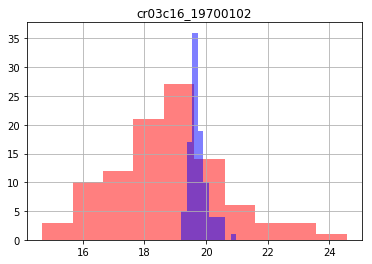

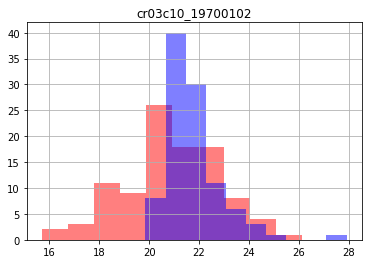

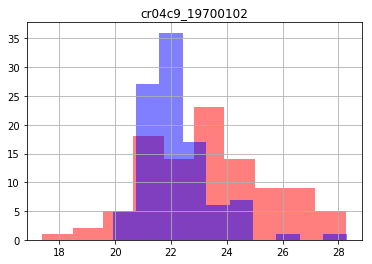

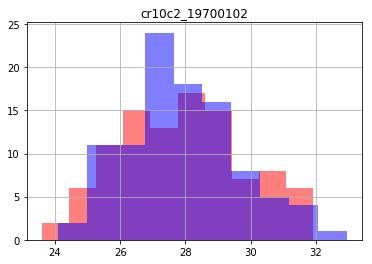

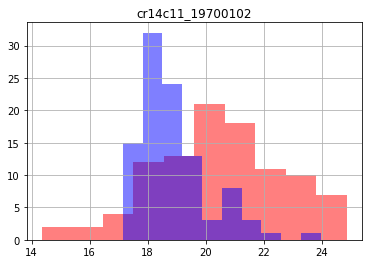

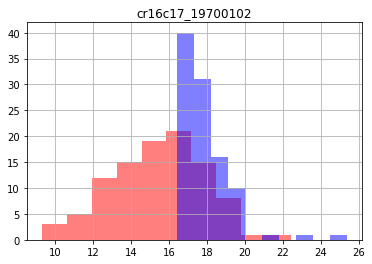

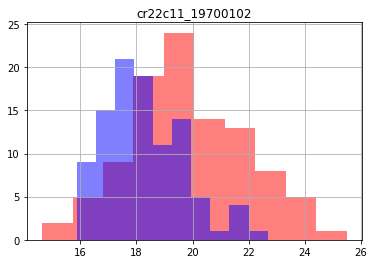

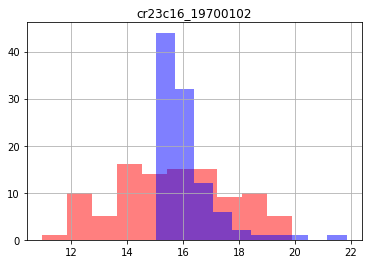

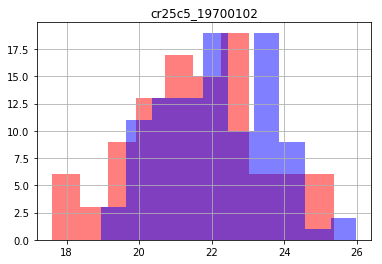

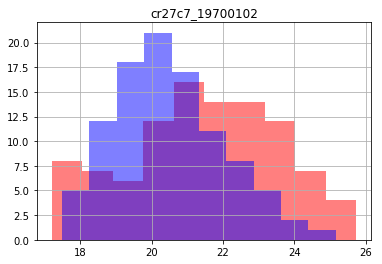

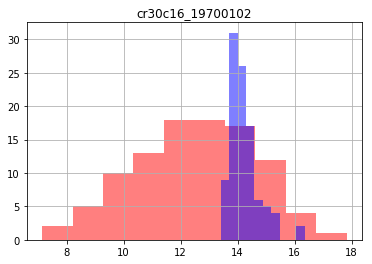

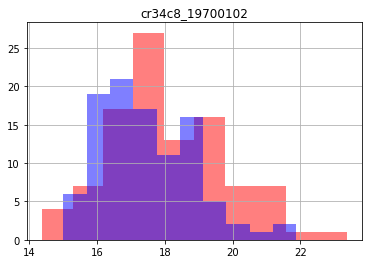

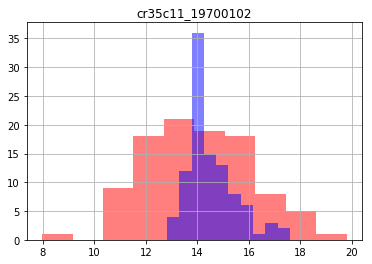

In [20]:
for oname in pst.nnz_obs_names:
    ax = ies.obsensemble_0.loc[:,oname].hist(bins=10,alpha=0.5,color='r')
    ies.obsensemble.loc[:,oname].hist(bins=10,ax=ax,alpha=0.5,color='b')
    ax.set_title(oname)
    plt.show()

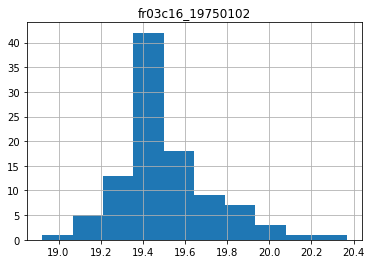

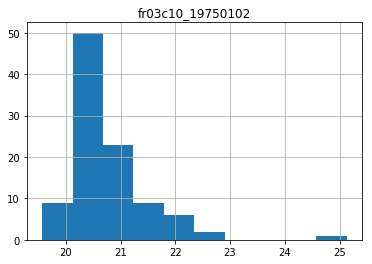

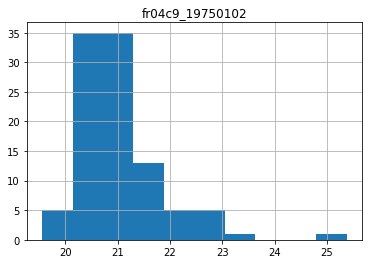

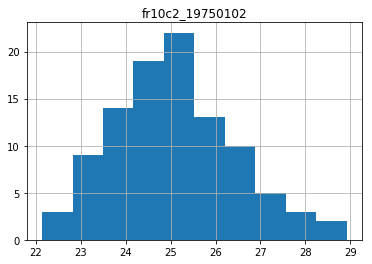

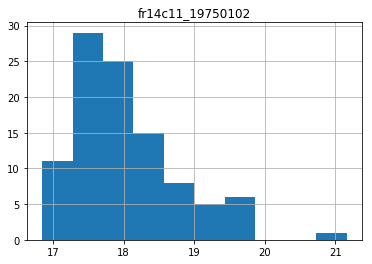

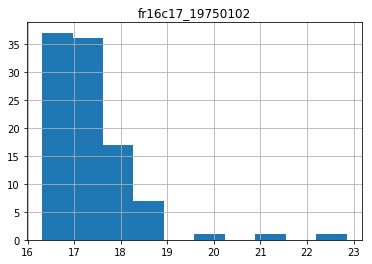

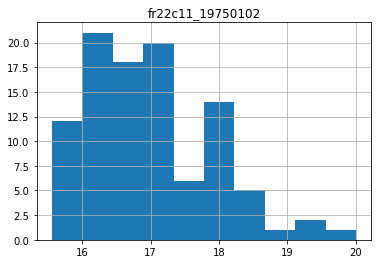

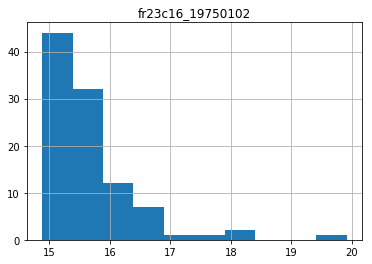

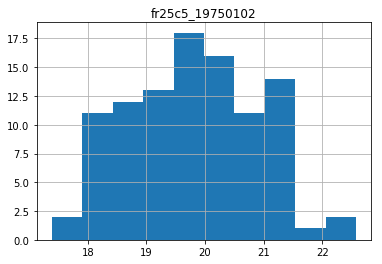

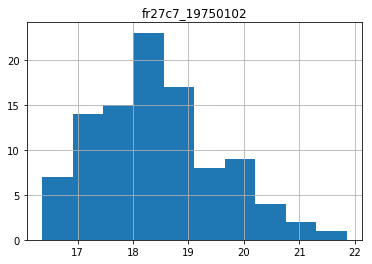

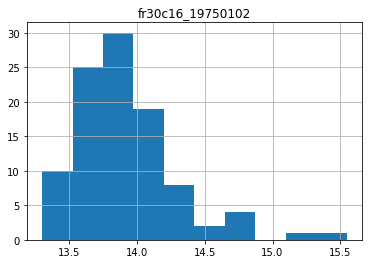

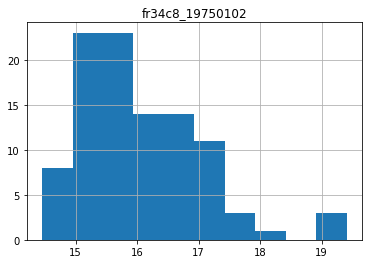

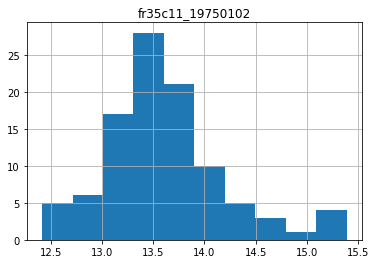

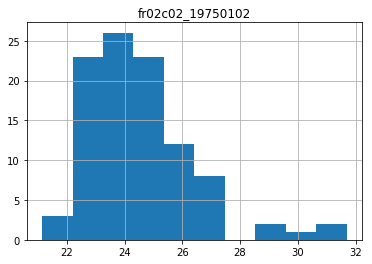

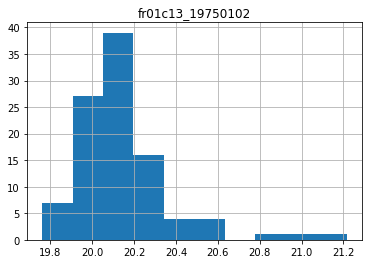

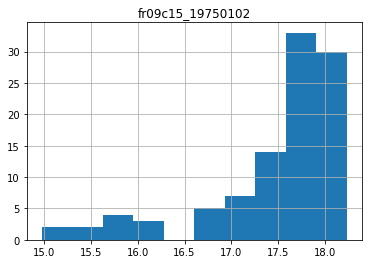

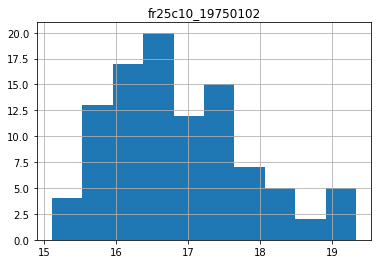

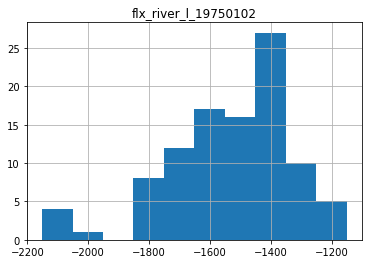

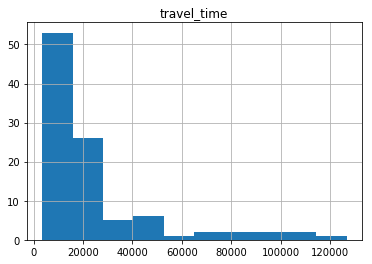

In [21]:
for forecast in pst.forecast_names:
    ax = ies.obsensemble.loc[:,forecast].hist(bins=10)
    ax.set_title(forecast)
    plt.show()

In [22]:
ies.total_runs

400

In [23]:
df_sum = pd.read_csv(pst_name+".iobj.csv")
df_sum

,iter_num,total_runs,lambda,min,max,mean,median,std,0000000001,0000000002,...,0000000091,0000000092,0000000093,0000000094,0000000095,0000000096,0000000097,0000000098,0000000099,0000000100
0,0,100,0.0000,21.284872,28390.559573,5282.176800,2511.3728353924303 33.642465,6723.566500,10755.809000,21210.790000,...,904.766790,17055.289000,4354.388100,2728.034600,141.756020,106.696570,4422.080000,18807.81300,NaN,NaN
1,1,200,1.0000,7.293358,2271.767568,148.670713,52.4061092652061 329.37469,181.181730,261.445840,46.660427,...,21.193610,15.414876,416.779250,8.953651,285.185400,46.322856,17.924329,62.96382,NaN,NaN
2,2,300,0.7500,7.463490,551.955229,53.046223,24.81654902524139 45.873232,20.987820,77.193419,25.026395,...,16.276638,21.113765,9.802369,7.463490,34.052039,14.851898,20.770807,95.16387,NaN,NaN
3,3,400,0.5625,4.812683,613.967955,46.203885,23.626784189884617 16.053544,9.917716,18.262343,54.635844,...,28.339152,10.503146,44.015546,8.994668,136.079590,25.421041,15.193042,613.96795,NaN,NaN


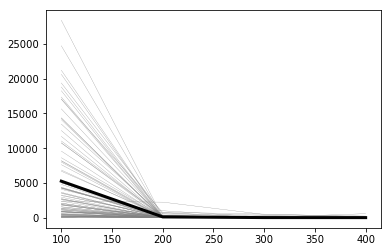

In [24]:
ax = plt.subplot(111)
real_cols = [c for c in df_sum.columns if c.startswith("0")]
[ax.plot(df_sum.total_runs,df_sum.loc[:,rc],'0.5',lw=0.25) for rc in real_cols]
ax.plot(df_sum.total_runs,df_sum.loc[:,"mean"],"k",lw=3)
plt.show()

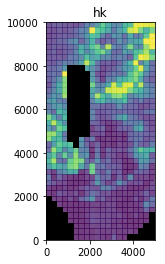

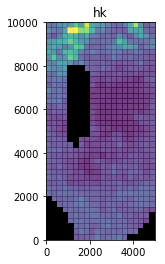

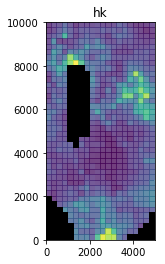

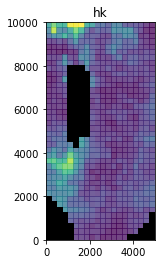

In [25]:
for real in ies.parensemble.index[:4]:
    arr = np.zeros((m.nrow,m.ncol))
    arr[hk_par.i,hk_par.j] = ies.parensemble.loc[real,hk_par.parnme]
    m.upw.hk[0] = arr
    m.upw.hk[0].plot(alpha=0.5)
    plt.show()